In [ ]:
# Exporting the notebook. It may take several seconds....

[NbConvertApp] Converting notebook Nasa_turbo-Predictive-Maintenance.ipynb to script
[NbConvertApp] Writing 6426 bytes to Nasa_turbo-Predictive-Maintenance.py


pandas==0.25.3
xgboost==1.2.1
matplotlib==3.0.2
Keras==2.4.3
seaborn==0.9.0
autofeat==1.1.3
numpy==1.18.5
scikit_learn==0.23.2


INFO: Successfully output requirements


In [5]:
##$xpr_param_component_name = data_fetch
##$xpr_param_component_type = pipeline_job 

In [6]:
import os
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import autofeat
from autofeat import FeatureSelector, AutoFeatRegressor

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, RobustScaler, QuantileTransformer
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV

from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from xgboost import XGBRegressor
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM

In [7]:
## $xpr_param_component_name = data_prep
## $xpr_param_component_type = pipeline_job


In [9]:
path = "/home/jovyan/predictive_maintenance/pipelines/pm-pipeline"
train_files = ['train_FD001.txt']
train_file = train_files[0]

In [10]:
def data_extraction(file):
    df = pd.read_csv(os.path.join(path, file), sep = ' ', header = None)
    print("Shape of training data: ",df.shape)
    return df

In [11]:
def data_cleaning(dataframe):
    dataframe_modified = dataframe.drop(dataframe.columns[[26, 27]], axis = 1) # dropping last two NaN columns
    dataframe_modified.columns = ['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
                     's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
                     's15', 's16', 's17', 's18', 's19', 's20', 's21']
    
    # Calculating the RUL (Remaining Useful Life) for each id
    rul = pd.DataFrame(dataframe_modified.groupby('id')['cycle'].max()).reset_index() # max cycles for each id
    rul.columns = ['id', 'maxCycles'] 
    train_df = dataframe_modified.merge(rul, on=['id'], how='left') 
    train_df['RUL'] = train_df['maxCycles'] - train_df['cycle']
    train_df.drop('maxCycles', axis=1, inplace=True) 
    return train_df

In [12]:
def create_training_and_test_data(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 0)
    return X_train, X_test, y_train, y_test

In [13]:
def normalization(X_train, X_test):
    scaler = QuantileTransformer(n_quantiles=10, output_distribution='normal')
    X_train_normalized = scaler.fit_transform(X_train)
    X_test_normalized = scaler.transform(X_test)
    return X_train_normalized, X_test_normalized

In [14]:
## $xpr_param_component_name = feature_engineering
## $xpr_param_component_type = pipeline_job

In [15]:
def feature_engineering(dataframe):
    dataframe_description = dataframe.describe()
    df_plot = dataframe.copy()
    df_corr = df_plot.corr(method='pearson')
    fig, ax = plt.subplots(figsize=(10,10))
    axes = sns.heatmap(df_corr, linewidths=.2)
    axes = dataframe_description.T.plot.bar(subplots=True, figsize=(20,15))
    data = dataframe.drop(['cycle','id'], axis=1)
    
    X = (data.iloc[:,:-1]).to_numpy()
    y = (data.iloc[:,-1]).to_numpy()
    
    #Creating training and test data
    X_train, X_test, y_train, y_test = create_training_and_test_data(X, y)
    
    #Normalizing train and test data
    X_train_normalized, X_test_normalized = normalization(X_train, X_test)
    
    #Feature Engineering using autofeat
    afreg = AutoFeatRegressor(verbose=1, feateng_steps = 2, featsel_runs = 1)
    X_train_transformed = afreg.fit_transform(X_train_normalized, y_train)
    X_test_transformed = afreg.transform(X_test_normalized)
    print("R^2 after feature engineering: %.4f" % afreg.score(X_test_transformed, y_test))  
    return X_train_transformed, X_test_transformed, y_train, y_test

In [16]:
## $xpr_param_component_name = training
## $xpr_param_component_type = pipeline_job


In [17]:
def ML_model(X_train, y_train, X_test, y_test):
    reg = GridSearchCV(RandomForestRegressor(), {'max_depth':[15], 'n_estimators':[20], 'criterion':['mse'], 'random_state':[0]}, cv=5, scoring = 'r2')
    
    model_ML = reg.fit(X_train, np.ravel(y_train))
    print("\nBest parameters from GridSearch = " + str(model_ML.best_params_))
    print("\nAverage R2 Score with 5-fold CV = " + str(model_ML.best_score_))
    y_test_pred = model_ML.predict(X_test)
    R2_test_ML = r2_score(y_test_pred, y_test)
    print("R2 Score on the test dataset with Random Forest = " + str(R2_test_ML))
    print("\n")
    return {model_ML, R2_test_ML}

In [18]:
def LSTM_model(X_train, y_train, X_test, y_test):
    # Normalization
    scaler = QuantileTransformer(n_quantiles=10, output_distribution='normal')
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    X_train_lstm = np.reshape(X_train,(X_train.shape[0], 1, X_train.shape[1])); y_train_lstm = y_train   
    X_test_lstm = np.reshape(X_test,(X_test.shape[0], 1, X_train.shape[1])); y_test_lstm = y_test 

    # Defining a 2-layer stacked LSTM
    model = Sequential()
    model.add(LSTM(32, activation='relu', input_shape=(1, X_train.shape[1]), return_sequences = True))
    model.add(LSTM(32, activation='relu', input_shape=(1, X_train.shape[1])))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    model.fit(X_train_lstm, y_train_lstm, epochs=20, validation_split=0.20)
    y_test_pred_lstm = model.predict(X_test_lstm)
    R2_test_lstm = r2_score(y_test_pred_lstm, y_test_lstm)
    print("R2 Score on the test dataset with LSTM = " + str(R2_test_lstm))
    return {model, R2_test_lstm}

In [19]:
# Extracting data
df_initial = data_extraction(train_file)

Shape of training data:  (20631, 28)


In [20]:
#Removing columns with NaN and adding the RUL column
df_cleaned = data_cleaning(df_initial)
df_cleaned.head()

id  cycle  setting1  setting2  setting3      s1      s2       s3       s4  \
0   1      1   -0.0007   -0.0004     100.0  518.67  641.82  1589.70  1400.60   
1   1      2    0.0019   -0.0003     100.0  518.67  642.15  1591.82  1403.14   
2   1      3   -0.0043    0.0003     100.0  518.67  642.35  1587.99  1404.20   
3   1      4    0.0007    0.0000     100.0  518.67  642.35  1582.79  1401.87   
4   1      5   -0.0019   -0.0002     100.0  518.67  642.37  1582.85  1406.22   

      s5  ...      s13      s14     s15   s16  s17   s18    s19    s20  \
0  14.62  ...  2388.02  8138.62  8.4195  0.03  392  2388  100.0  39.06   
1  14.62  ...  2388.07  8131.49  8.4318  0.03  392  2388  100.0  39.00   
2  14.62  ...  2388.03  8133.23  8.4178  0.03  390  2388  100.0  38.95   
3  14.62  ...  2388.08  8133.83  8.3682  0.03  392  2388  100.0  38.88   
4  14.62  ...  2388.04  8133.80  8.4294  0.03  393  2388  100.0  38.90   

       s21  RUL  
0  23.4190  191  
1  23.4236  190  
2  23.3442  189  
3  23.3739  188  
4  23.4044  187  

[5 rows x 27 columns]

[AutoFeat] The 2 step feature engineering process could generate up to 14196 features.
[AutoFeat] With 16504 data points this new feature matrix would use about 0.94 gb of space.
[feateng] Step 1: transformation of original features
[feateng] Generated 74 transformed features from 24 original features - done.
[feateng] Step 2: first combination of features


/home/jovyan/dilip.upadhyay/.conda-envs/xpressoenv/lib/python3.7/site-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/jovyan/dilip.upadhyay/.conda-envs/xpressoenv/lib/python3.7/site-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


/home/jovyan/dilip.upadhyay/.conda-envs/xpressoenv/lib/python3.7/site-packages/numpy/core/_methods.py:195: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


[feateng] Generated 4104 feature combinations from 4753 original feature tuples - done.
[feateng] Generated altogether 4782 new features in 2 steps
[feateng] Removing correlated features, as well as additions at the highest level


/home/jovyan/dilip.upadhyay/.conda-envs/xpressoenv/lib/python3.7/site-packages/sympy/__init__.py:676: SymPyDeprecationWarning: 

importing sympy.core.add with 'from sympy import *' has been
deprecated since SymPy 1.6. Use import sympy.core.add instead. See
https://github.com/sympy/sympy/issues/18245 for more info.

  deprecated_since_version="1.6").warn()
/home/jovyan/dilip.upadhyay/.conda-envs/xpressoenv/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1546: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


[feateng] Generated a total of 3958 additional features
[featsel] Scaling data...done.
[featsel] Feature selection run 1/1
[featsel] 65 features after 1 feature selection runs
[featsel] 63 features after correlation filtering
[featsel] 55 features after noise filtering
[AutoFeat] Computing 42 new features.
[AutoFeat]    42/   42 new features ...done.
[AutoFeat] Final dataframe with 66 feature columns (42 new).
[AutoFeat] Training final regression model.
[AutoFeat] Trained model: largest coefficients:
126.65897337421993
-16.944038 * x011
-14.392753 * x016
-10.848997 * x013
8.645399 * x014
-7.723723 * Abs(x006)
7.329194 * x011*Abs(x013)
-6.382267 * x006
5.749705 * x023
-4.502982 * Abs(x015)
4.244667 * x009
3.839596 * x006**2*Abs(x016)
-3.726183 * x017
3.634470 * x022
-3.624397 * x006*Abs(x010)
-3.440497 * Abs(x014)
3.222642 * x010*x016
-2.695277 * x004*x010
-2.454860 * x004*Abs(x015)
-2.446607 * x019
-2.425086 * x011**2
-2.246155 * x005*Abs(x015)
2.188508 * x015**2*x016
2.095639 * x011*x

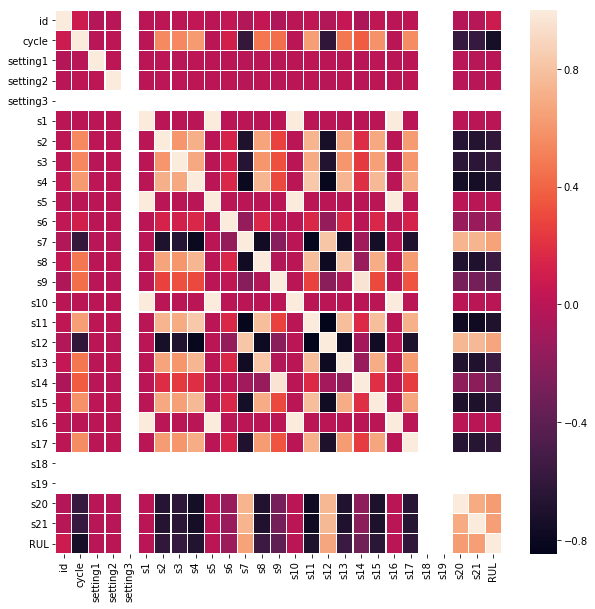

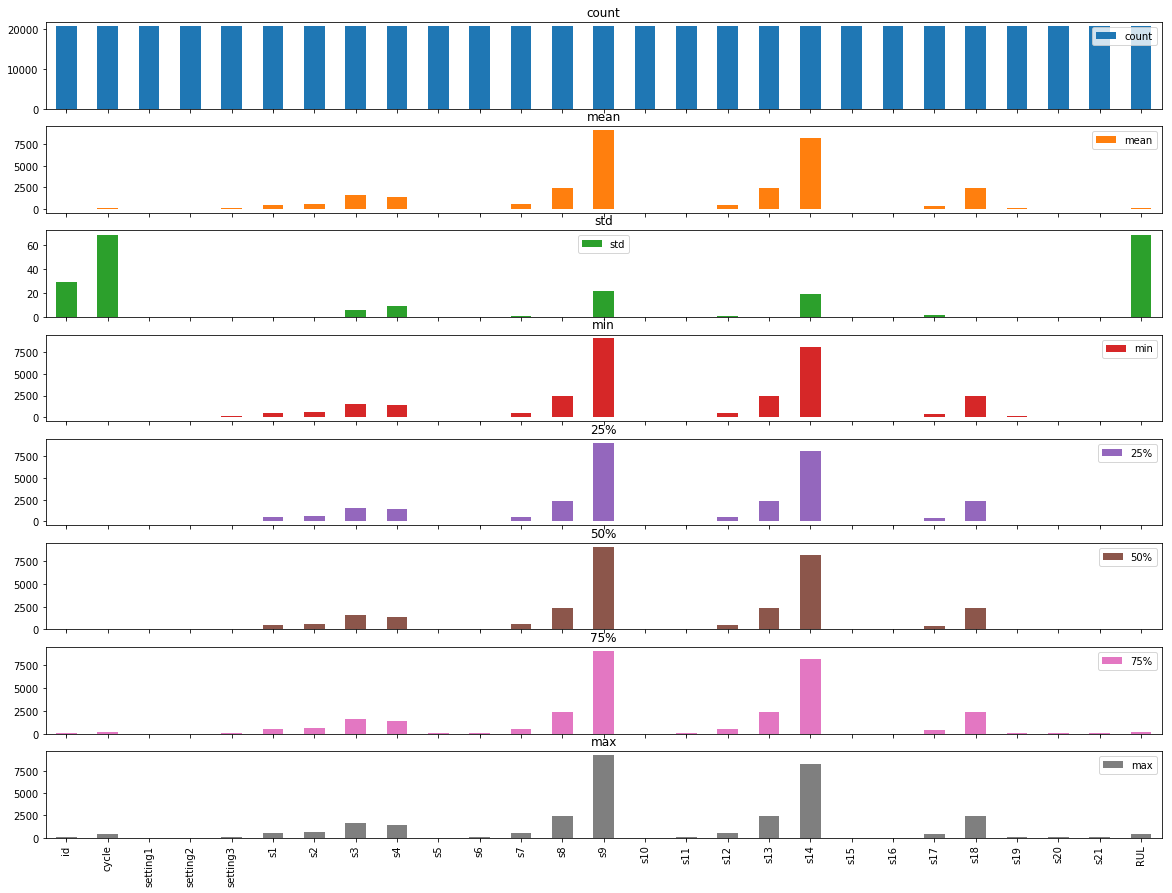

In [21]:
# Train-test split, normalization and feature engineering
X_train_transformed, X_test_transformed, y_train, y_test = feature_engineering(df_cleaned)

In [22]:
# Printing transformed dataset after feature engineering 
X_train_transformed.head()

x000     x001      x002      x003      x004      x005      x006  \
0 -1.459439  0.00000 -5.199338 -5.199338 -0.282216 -0.611207  0.238732   
1 -0.631402  1.22064 -5.199338 -5.199338 -0.802572 -0.527529  0.135212   
2  0.631402  0.00000 -5.199338 -5.199338  1.297543  1.829235  1.293303   
3 -0.764710  0.76471 -5.199338 -5.199338  0.529453 -0.400363 -0.511780   
4  1.230477  0.13971 -5.199338 -5.199338  1.230477 -0.036299  1.473681   

       x007      x008      x009  ...  x006**2*x014**2  x014**2*x023**2  \
0 -5.199338  5.199338 -0.171033  ...         0.004126         0.011732   
1 -5.199338  5.199338  0.577662  ...         0.002357         0.035185   
2 -5.199338  5.199338 -1.492866  ...         4.012012         3.778019   
3 -5.199338  5.199338  1.029957  ...         0.249339         0.106482   
4 -5.199338  5.199338 -1.368604  ...         0.010546         0.002485   

   x023**2*Abs(x016)  x001**3*exp(x023)  x006**2*Abs(x016)  x011**3*exp(x009)  \
0           0.142384           0.000000           0.050074           0.787425   
1           0.121070           3.066668           0.008109          -0.003592   
2           2.496789           0.000000           2.651429          -0.901071   
3           0.081571           0.624796           0.191006           0.843248   
4           0.263272           0.001334           1.117352          -0.042043   

   x011**2*exp(x014)  x016**3*exp(x023)  x011**2*exp(x023)  x011**3*exp(x014)  
0           0.730250           1.014408           1.429407           0.713894  
1           0.022853          -0.147119           0.026910          -0.002887  
2           0.536359          -1.135508           0.719481          -0.852098  
3           1.191710           0.541862           0.627599           0.798707  
4           0.322833          -0.066601           0.147247          -0.177147  

[5 rows x 66 columns]

In [23]:
# # Fitting Random Forest model
print("1. Using Random Forest:\n")
model_ML, R2_test_ML = ML_model(X_train_transformed, y_train, X_test_transformed, y_test)

# Fitting LSTM model
print("2. Using LSTM:\n")
model_lstm, R2_test_lstm = LSTM_model(X_train_transformed, y_train, X_test_transformed, y_test)

1. Using Random Forest:


Best parameters from GridSearch = {'criterion': 'mse', 'max_depth': 15, 'n_estimators': 20, 'random_state': 0}

Average R2 Score with 5-fold CV = 0.6256958889654294
R2 Score on the test dataset with Random Forest = 0.44165482705317427


2. Using LSTM:

Epoch 1/20
413/413 [==============================] - 2s 4ms/step - loss: 4898.1328 - val_loss: 1765.2469
Epoch 2/20
413/413 [==============================] - 1s 3ms/step - loss: 1776.3450 - val_loss: 1689.8024
Epoch 3/20
413/413 [==============================] - 1s 3ms/step - loss: 1742.0383 - val_loss: 1671.7836
Epoch 4/20
413/413 [==============================] - 1s 3ms/step - loss: 1727.1407 - val_loss: 1675.1409
Epoch 5/20
413/413 [==============================] - 1s 3ms/step - loss: 1718.0366 - val_loss: 1668.4738
Epoch 6/20
413/413 [==============================] - 1s 3ms/step - loss: 1713.5585 - val_loss: 1671.3354
Epoch 7/20
413/413 [==============================] - 1s 3ms/step - loss: 1707.7325 -